In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [30]:
img_size = 224
batch_size = 32

In [31]:
data_dir = './dataset/ck+/oversampled_train'

# Preprocessing and augmentation for dataset balancing
# Preprocessing and augmentation for dataset balancing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=00,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Print class indices to verify all classes are recognized
print("Train Class Indices:", train_generator.class_indices)
print("Public Test Class Indices:", val_generator.class_indices)

Found 1883 images belonging to 7 classes.
Found 469 images belonging to 7 classes.
Train Class Indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sad': 5, 'surprised': 6}
Public Test Class Indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sad': 5, 'surprised': 6}


In [32]:
print("total images:", len(train_generator.filenames + val_generator.filenames))

total images: 2352


In [33]:
print("Class Indices:", train_generator.class_indices)
images, labels = next(train_generator)
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Class Indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sad': 5, 'surprised': 6}
Batch shape: (32, 224, 224, 3)
Labels shape: (32, 7)


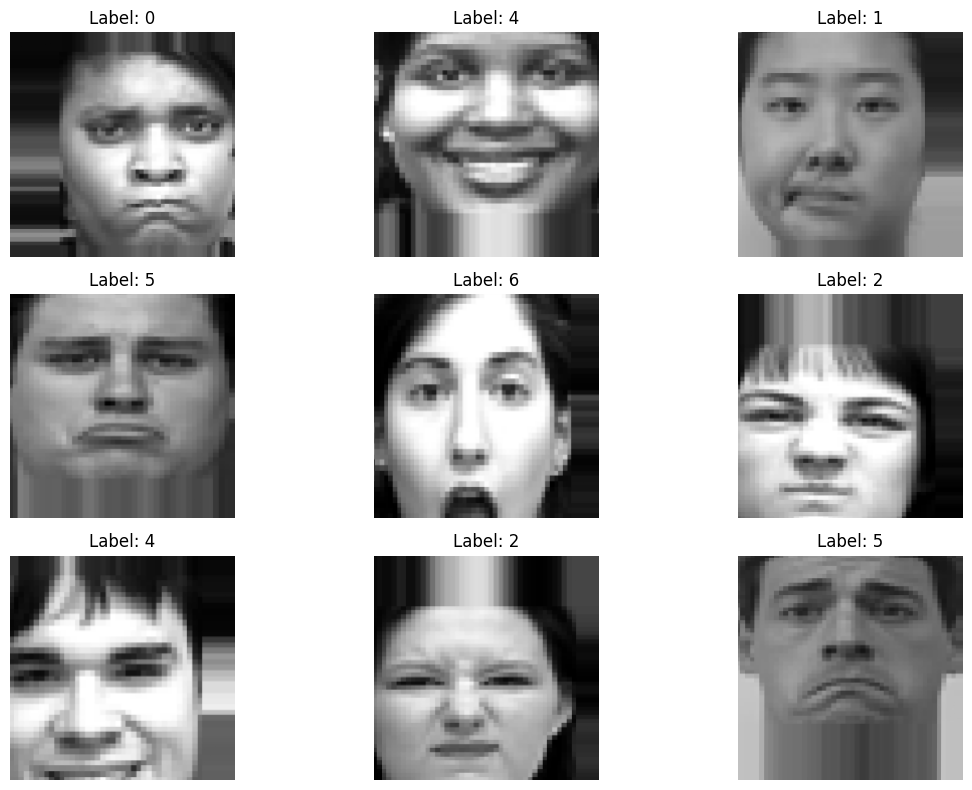

In [34]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display a few sample images
plt.figure(figsize=(12, 8))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Images are already rescaled
    plt.title(f"Label: {np.argmax(labels[i])}")  # Show the class label
    plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
from sklearn.utils.class_weight import compute_class_weight
# 2. Compute Class Weights for Balancing
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [36]:
from tensorflow.keras.applications import VGG16

# 3. Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the convolutional base



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
# 4. Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [38]:
# 5. Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
import tensorflow as tf
print(tf.__version__)  # Make sure it's at least 2.8+


2.18.0


In [40]:
# 6. Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    # class_weight=class_weight_dict,
    verbose=1
)

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 7), output.shape=(None, 32)

In [ ]:


# 7. Evaluate Model
loss, accuracy = model.evaluate(val_generator, verbose=1)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions on the validation set
val_generator.reset()  # Reset generator to avoid any issues with batch indexing
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Create the confusion matrix
class_names = list(val_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Plot loss and accuracy graphs
def plot_training_history(history):
    """Plots training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit()
plot_training_history(history)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Step 1: Generate predictions and true labels
val_generator.reset()  # Reset generator to avoid batch issues
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class indices
y_true = val_generator.classes  # True labels

# Step 2: Confusion Matrix
class_names = list(val_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Step 4: Overall Metrics (Weighted Averages)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# Step 5: Loss and Accuracy Graphs
def plot_training_history(history):
    """Plots training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` contains the training history from model.fit()
plot_training_history(history)

In [ ]:

# Define the test dataset directory
test_dir = './dataset/ck+/test-ck+/test'  # Replace with the actual test dataset path

# Set up the ImageDataGenerator for the test dataset
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create the test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure predictions align with true labels
)

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Step 1: Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 2: Generate predictions and true labels
test_generator.reset()  # Reset generator to avoid indexing issues
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
y_true = test_generator.classes  # True labels

# Step 3: Confusion Matrix
class_names = list(test_generator.class_indices.keys())  # Class names from the generator
cm = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Step 4: Classification Report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Step 5: Overall Metrics (Weighted Averages)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")